# _Convolutional_ Variational Autoencoder - CelebA Dataset & PyTorch

- [VAE_CelebA_Code](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/2_VAE_celeba-sigmoid_mse.ipynb)

- [helper functions](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/helper_data.py)

- [YouTube video](https://www.youtube.com/watch?v=sul2ExoUrnw)

- The Convolutional VAE architecture is based on the researh paper [Deep Feature Consistent Variational Autoencoder](https://arxiv.org/pdf/1610.00291.pdf)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### [Large-scale CelebFaces Attributes (CelebA) Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html)


Targets are 40-dimensional vectors representing:

    00 - 5_o_Clock_Shadow
    01 - Arched_Eyebrows
    02 - Attractive 
    03 - Bags_Under_Eyes
    04 - Bald
    05 - Bangs
    06 - Big_Lips
    07 - Big_Nose
    08 - Black_Hair
    09 - Blond_Hair
    10 - Blurry 
    11 - Brown_Hair 
    12 - Bushy_Eyebrows 
    13 - Chubby 
    14 - Double_Chin 
    15 - Eyeglasses 
    16 - Goatee 
    17 - Gray_Hair 
    18 - Heavy_Makeup 
    19 - High_Cheekbones 
    20 - Male 
    21 - Mouth_Slightly_Open 
    22 - Mustache 
    23 - Narrow_Eyes 
    24 - No_Beard 
    25 - Oval_Face 
    26 - Pale_Skin 
    27 - Pointy_Nose 
    28 - Receding_Hairline 
    29 - Rosy_Cheeks 
    30 - Sideburns 
    31 - Smiling 
    32 - Straight_Hair 
    33 - Wavy_Hair 
    34 - Wearing_Earrings 
    35 - Wearing_Hat 
    36 - Wearing_Lipstick 
    37 - Wearing_Necklace 
    38 - Wearing_Necktie 
    39 - Young         


- [Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and [Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset)

- [Unable to load CelebA dataset GitHub issue](https://github.com/pytorch/vision/issues/2262)

- [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html)

In [7]:
# Define transformations for CelebA dataset-
transforms_apply = transforms.Compose(
    [
        torchvision.transforms.CenterCrop((128, 128)),
        transforms.ToTensor()
    ]
)

In [8]:
# Load CelebA dataset-
train_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'train',
    transform = transforms_apply, download = True
)

valid_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'valid',
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'test',
    transform = transforms_apply, download = True
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset = valid_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
)

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)}, valid_dataset: {len(valid_dataset)}"
      f" & test_dataet: {len(test_dataset)}")

Sizes of train_dataset: 162770, valid_dataset: 19867 & test_dataet: 19962


In [11]:
print(f"Sizes of train_loader: {len(train_loader)}, valid_loader = {len(valid_loader)}"
      f" & test_loader: {len(test_loader)}")

Sizes of train_loader: 2544, valid_loader = 311 & test_loader: 312


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(valid_dataset) / batch_size, len(test_dataset) / batch_size

(2543.28125, 310.421875, 311.90625)

In [13]:
# Sanity check - Check dataset-
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])


In [14]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 3, 128, 128]) & labels.shape: torch.Size([64, 40])


In [15]:
print(f"min pixel value = {images.min()} & max pixel value = {images.max()}")

min pixel value = 0.0 & max pixel value = 1.0


In [16]:
images = images.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

In [17]:
images = np.transpose(images, (0, 2, 3, 1))

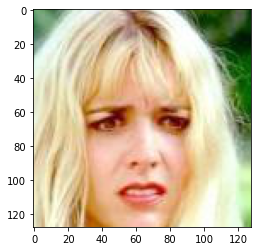

In [18]:
plt.imshow(images[0])

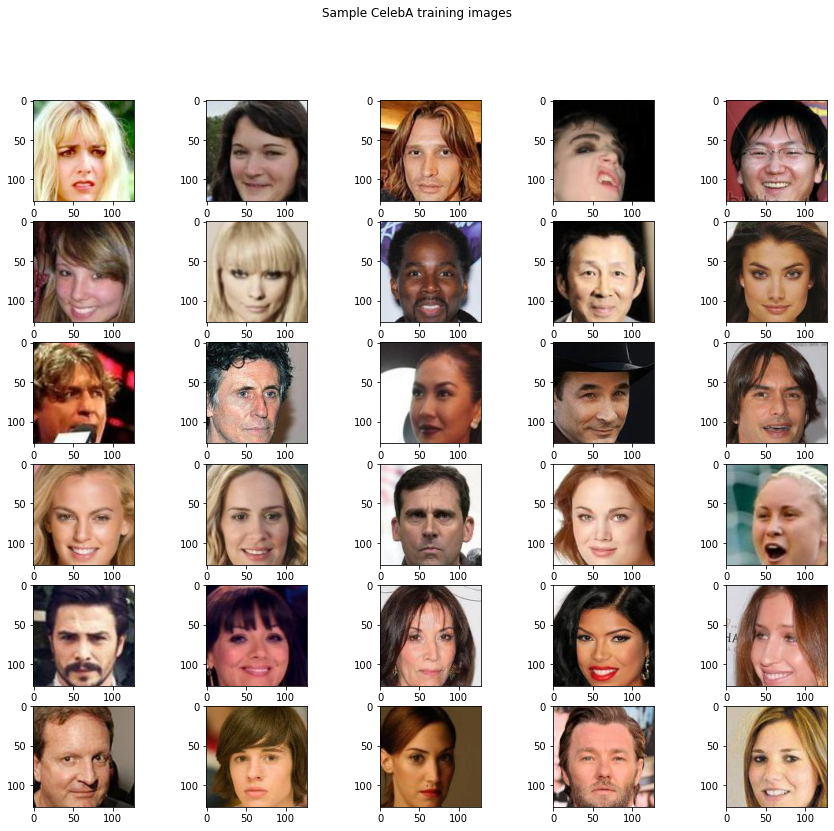

In [19]:
# Visualize 30 images from training set-
plt.figure(figsize = (15, 13))
for i in range(30):
    # 6 rows & 5 columns-
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CelebA training images")
plt.show()

In [20]:
del images, labels

### Define VAE architecture using _Convolutional_ layers

In [21]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


In [22]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]
    

In [65]:
class VAE_CelebA(nn.Module):
    def __init__(self, latent_space = 200):
        super(VAE_CelebA, self).__init__()
        
        self.latent_space = latent_space
        
        # Define encoder architecture-
        self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels = 3, out_channels = 32,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 32),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 32, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                nn.Flatten(),
        )    
        
        # Define mean & log-variance vectors to represent latent space 'z'-
        self.mu = torch.nn.Linear(in_features = 4096, out_features = self.latent_space)
        self.log_var = torch.nn.Linear(in_features = 4096, out_features = self.latent_space)
        
        # Define encoder architecture-
        self.decoder = nn.Sequential(
                torch.nn.Linear(
                    in_features = self.latent_space, out_features = 4096
                ),
                Reshape(-1, 64, 8, 8),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 32,
                    stride = 2, kernel_size = 3,
                    padding = 1),
                nn.BatchNorm2d(num_features = 32),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 32, out_channels = 3,
                    stride = 2, kernel_size = 3,
                    padding = 1
                ),
                
                # Trim: 3x129x129 -> 3x128x128
                Trim(),
            
                # Due to input image being in the scale [0, 1], use sigmoid-
                nn.Sigmoid()
                )

        
    def reparameterize(self, mu, log_var):
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        # eps = torch.randn_like(log_var).to(log_var.get_device())
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(log_var / 2.0) 
        return z
    
    
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.mu(x), self.log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
        
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # Get mean & log-var vectors representing latent space distribution-
        mu, log_var = self.mu(x), self.log_var(x)
        
        # Obtain the latent vector 'z' using reparameterization-
        z = self.reparameterize(mu = mu, log_var = log_var)
        
        # Get reconstruction using 'z' as input to decoder-
        x_recon = self.decoder(z)
        
        return x_recon, mu, log_var
        
        
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu, log_var = self.mu(x), self.log_var(x)
        z = self.reparameterize(mu = mu, log_var = log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        
        x_recon = self.decoder(z)
        print(f"Decoder output shape: {x_recon.shape}")
        del x, x_recon, mu, log_var, z
        return None

    

In [24]:
# Initialize an instance of defined VAE architecture-
model = VAE_CelebA(latent_space = 200)

# Push model to GPU (if available)-
model.to(device)

VAE_CelebA(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [25]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([32, 3, 3, 3]) has 864 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([64, 32, 3, 3]) has 18432 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([200, 4096]) has 819200 parameters
layer.shape = torch.Size([200]) has 200 parameters
layer.shape = torch.Size([200, 4096]) has 819200 parameters
layer.shape = torch.Size([200]) has 200 parameters
layer.shape = torch.Size([4096, 200]) has 819200 parameters
layer.shape = torch.Size([4096]) has 4096 parameters
layer.shape = torch.Size([64

In [26]:
print(f"Total number of parameters in VAE model = {tot_params}")

Total number of parameters in VAE model = 2649075


### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some _initial variance_.

In [27]:
for x in model.mu.parameters():
    print(x.shape, x.nelement())

torch.Size([200, 4096]) 819200
torch.Size([200]) 200


In [28]:
log_var_wts = model.log_var.weight
mu_wts = model.mu.weight

In [29]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [30]:
mu_wts.shape, log_var_wts.shape

((200, 4096), (200, 4096))

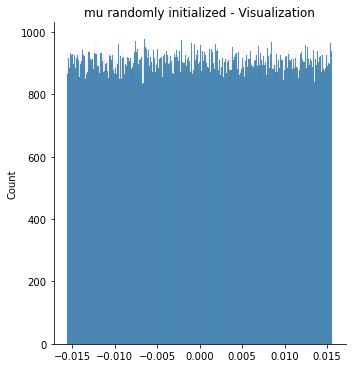

In [31]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

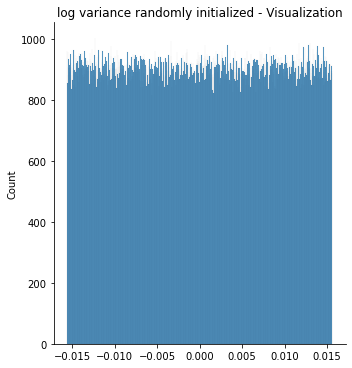

In [32]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [33]:
del mu_wts, log_var_wts

In [34]:
# Sanity check-
images, labels = next(iter(train_loader))

In [35]:
# Push data to 'device'-
images = images.to(device)

In [36]:
images.shape, labels.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 40]))

In [37]:
# Get min and max pixel values-
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [38]:
# Get output from VAE-
recon_images, mu, log_var = model(images)

In [39]:
model.shape_computation(images)

Input shape: torch.Size([64, 3, 128, 128])
Encoder output shape: torch.Size([64, 4096])
mu.shape: torch.Size([64, 200]), log_var.shape: torch.Size([64, 200]) & z.shape: torch.Size([64, 200])
Decoder output shape: torch.Size([64, 3, 128, 128])


In [40]:
# Get min & max reconstructed pixel values-
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.00175237, dtype=float32), array(0.9985538, dtype=float32))

In [41]:
del recon_images, mu, log_var

In [34]:
print(f"Train model using Adam gradient descent optimizer, learning rate = {learning_rate:.4f}")

Train model using Adam gradient descent optimizer, learning rate = 0.0010


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  

In [36]:
def total_loss(data, data_recon, mu, log_var, alpha = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-Divergence loss:
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    
    # kl_div.shape
    # torch.Size([64])
    
    batchsize = kl_div.size(0)

    # Compute average KL-divergence over batch size-
    kl_div = kl_div.mean()
    
    
    # Compute Reconstruction loss:
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    # Reshape recon_loss so that it is the batchsize and a vector. So, instead
    # of having a tensor, it is now a matrix (table). Then, sum over the pixels.
    # This is equivalent to summing over the latent dimensions for kl_div above.
    # We are summing first the squared error over the pixels and then average over
    # the batch dimensions below-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([64, 784])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + kl_div
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Sanity check-
final_loss, recon_loss, kl_div_loss = total_loss(
    data = images, data_recon = recon_images,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"final loss = {final_loss.cpu().detach().numpy():.4f},"
      f" reconstruction loss = {recon_loss.cpu().detach().numpy():.4f}"
      f" & kl-div loss = {kl_div_loss.cpu().detach().numpy():.4f}"
     )
'''
# final loss = 5167.6367, reconstruction loss = 5132.8906 & kl-div loss = 34.7462

In [37]:
def train_one_epoch(model, dataloader, alpha):
    
    # Push model to 'device'-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            # print(images.shape, labels.shape)
            
            # Push images to 'device'-
            images = images.to(device)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform forward propagation-
            recon_images, mu, log_var = model(images)
            
            # Compute different losses-
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = images, data_recon = recon_images,
                mu = mu, log_var = log_var,
                alpha = alpha
            )
            
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
            # Compute gradients wrt total loss-
            final_loss.backward()
            
            # Perform gradient descent-
            optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss
        

In [38]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                # Push data points to 'device'-
                images = images.to(device)
                
                # Perform forward propagation-
                recon_images, mu, log_var = model(images)
                
                # Compute different losses-
                final_loss, recon_loss, kl_div_loss = total_loss(
                    data = images, data_recon = recon_images,
                    mu = mu, log_var = log_var,
                    alpha = alpha
                )
                
                # Update losses-
                running_final_loss += final_loss.item()
                running_kl_loss += kl_div_loss.cpu().detach().numpy()
                running_recon_loss += recon_loss.cpu().detach().numpy()
            
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss


In [ ]:
'''
# Sanity check-
train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = 1
)
'''

In [ ]:
'''
# Sanity check-
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = valid_loader,
    alpha = 1
)
'''

In [ ]:
'''
print(f"After one epoch: train loss = {train_loss:.4f}, recon loss = {recon_train_loss:.4f}"
      f" & kl-div loss = {kl_train_loss:.4f}"
     )
'''
# After one epoch: train loss = 85.6438, recon loss = 85.0982 & kl-div loss = 0.5455

In [ ]:
'''
print(f"After one epoch: val train loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f}"
      f" & val kl-div loss = {val_kl_loss:.4f}"
     )
'''
# After one epoch: val train loss = 72.6595, val recon loss = 72.5269 & val kl-div loss = 0.1325

### Train model without learning rate scheduler, with _early-stopping_ criterion

In [47]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
# loc_patience = 0

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [48]:
# Python3 dict to contain training metrics-
train_history = {}

In [49]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [50]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [51]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = valid_loader,
        alpha = alpha
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        # Update for lowest val_loss so far-
        best_val_loss = val_loss
        
        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation loss-
        torch.save(model.state_dict(), "VAE_CelebA_best_val_loss.pth")
    
    
    '''
    # Code for manual Early Stopping:
    if (val_epoch_loss < best_val_loss) and \
    (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    
    

Validation: : 100%|██████████| 312/312 [00:27<00:00, 11.54batch/s]


Epoch = 1; train loss = 14.3832 , kl-loss = 2.3142, recon loss = 12.0690 , val loss = 9.6340, val kl-loss = 2.0426  & val recon loss = 7.5914
Saving model with lowest val_loss = 9.6340



Validation: : 100%|██████████| 312/312 [00:12<00:00, 24.11batch/s]


Epoch = 2; train loss = 10.8583 , kl-loss = 2.1963, recon loss = 8.6620 , val loss = 8.8290, val kl-loss = 2.0110  & val recon loss = 6.8180
Saving model with lowest val_loss = 8.8290



Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.27batch/s]


Epoch = 3; train loss = 10.3140 , kl-loss = 2.2193, recon loss = 8.0947 , val loss = 8.8200, val kl-loss = 2.0568  & val recon loss = 6.7632
Saving model with lowest val_loss = 8.8200



Validation: : 100%|██████████| 312/312 [00:12<00:00, 24.97batch/s]


Epoch = 4; train loss = 10.0229 , kl-loss = 2.2356, recon loss = 7.7873 , val loss = 8.3465, val kl-loss = 2.0974  & val recon loss = 6.2491
Saving model with lowest val_loss = 8.3465



Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.38batch/s]


Epoch = 5; train loss = 9.8112 , kl-loss = 2.2445, recon loss = 7.5667 , val loss = 8.4698, val kl-loss = 2.0749  & val recon loss = 6.3950


Validation: : 100%|██████████| 312/312 [00:14<00:00, 22.25batch/s]


Epoch = 6; train loss = 9.6672 , kl-loss = 2.2487, recon loss = 7.4184 , val loss = 8.4162, val kl-loss = 2.1395  & val recon loss = 6.2767


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.57batch/s]


Epoch = 7; train loss = 9.5472 , kl-loss = 2.2516, recon loss = 7.2957 , val loss = 8.2101, val kl-loss = 2.1226  & val recon loss = 6.0875
Saving model with lowest val_loss = 8.2101



Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.17batch/s]


Epoch = 8; train loss = 9.4649 , kl-loss = 2.2541, recon loss = 7.2108 , val loss = 8.3008, val kl-loss = 2.1089  & val recon loss = 6.1920


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.30batch/s]


Epoch = 9; train loss = 9.3928 , kl-loss = 2.2530, recon loss = 7.1398 , val loss = 8.5201, val kl-loss = 2.0439  & val recon loss = 6.4762


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.52batch/s]


Epoch = 10; train loss = 9.3337 , kl-loss = 2.2537, recon loss = 7.0801 , val loss = 7.9758, val kl-loss = 2.1252  & val recon loss = 5.8506
Saving model with lowest val_loss = 7.9758



Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.82batch/s]


Epoch = 11; train loss = 9.2972 , kl-loss = 2.2548, recon loss = 7.0424 , val loss = 8.3088, val kl-loss = 2.0697  & val recon loss = 6.2391


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.40batch/s]


Epoch = 12; train loss = 9.2472 , kl-loss = 2.2555, recon loss = 6.9917 , val loss = 8.3223, val kl-loss = 2.0463  & val recon loss = 6.2760


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.36batch/s]


Epoch = 13; train loss = 9.2148 , kl-loss = 2.2569, recon loss = 6.9579 , val loss = 8.3453, val kl-loss = 2.0902  & val recon loss = 6.2552


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.50batch/s]


Epoch = 14; train loss = 9.1914 , kl-loss = 2.2573, recon loss = 6.9341 , val loss = 8.1276, val kl-loss = 2.1236  & val recon loss = 6.0040


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.41batch/s]


Epoch = 15; train loss = 9.1568 , kl-loss = 2.2590, recon loss = 6.8978 , val loss = 8.3184, val kl-loss = 2.0464  & val recon loss = 6.2720


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.48batch/s]


Epoch = 16; train loss = 9.1403 , kl-loss = 2.2601, recon loss = 6.8802 , val loss = 8.2634, val kl-loss = 2.1594  & val recon loss = 6.1040


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.50batch/s]


Epoch = 17; train loss = 9.1161 , kl-loss = 2.2602, recon loss = 6.8558 , val loss = 8.0390, val kl-loss = 2.1018  & val recon loss = 5.9372


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.42batch/s]


Epoch = 18; train loss = 9.1000 , kl-loss = 2.2621, recon loss = 6.8379 , val loss = 9.0228, val kl-loss = 2.0463  & val recon loss = 6.9764


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.47batch/s]


Epoch = 19; train loss = 9.0821 , kl-loss = 2.2629, recon loss = 6.8191 , val loss = 8.3441, val kl-loss = 2.0862  & val recon loss = 6.2579


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.48batch/s]


Epoch = 20; train loss = 9.0651 , kl-loss = 2.2627, recon loss = 6.8024 , val loss = 8.4279, val kl-loss = 2.0680  & val recon loss = 6.3599


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.59batch/s]


Epoch = 21; train loss = 9.0509 , kl-loss = 2.2635, recon loss = 6.7873 , val loss = 8.6178, val kl-loss = 2.1156  & val recon loss = 6.5022


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.46batch/s]


Epoch = 22; train loss = 9.0309 , kl-loss = 2.2640, recon loss = 6.7669 , val loss = 7.9570, val kl-loss = 2.1376  & val recon loss = 5.8194
Saving model with lowest val_loss = 7.9570



Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.62batch/s]


Epoch = 23; train loss = 9.0238 , kl-loss = 2.2649, recon loss = 6.7590 , val loss = 8.4820, val kl-loss = 2.1033  & val recon loss = 6.3787


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.02batch/s]


Epoch = 24; train loss = 9.0132 , kl-loss = 2.2650, recon loss = 6.7481 , val loss = 8.3222, val kl-loss = 2.1412  & val recon loss = 6.1810


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.55batch/s]


Epoch = 25; train loss = 8.9984 , kl-loss = 2.2658, recon loss = 6.7326 , val loss = 8.3295, val kl-loss = 2.1322  & val recon loss = 6.1973


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.68batch/s]


Epoch = 26; train loss = 8.9929 , kl-loss = 2.2667, recon loss = 6.7262 , val loss = 8.2923, val kl-loss = 2.0871  & val recon loss = 6.2052


Validation: : 100%|██████████| 312/312 [00:13<00:00, 22.81batch/s]


Epoch = 27; train loss = 8.9802 , kl-loss = 2.2670, recon loss = 6.7132 , val loss = 8.3091, val kl-loss = 2.1438  & val recon loss = 6.1653


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.62batch/s]


Epoch = 28; train loss = 8.9770 , kl-loss = 2.2690, recon loss = 6.7080 , val loss = 8.5882, val kl-loss = 2.1479  & val recon loss = 6.4403


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.65batch/s]


Epoch = 29; train loss = 8.9718 , kl-loss = 2.2687, recon loss = 6.7031 , val loss = 8.1873, val kl-loss = 2.1131  & val recon loss = 6.0742


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.71batch/s]


Epoch = 30; train loss = 8.9600 , kl-loss = 2.2697, recon loss = 6.6903 , val loss = 8.2808, val kl-loss = 2.1199  & val recon loss = 6.1610


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.52batch/s]


Epoch = 31; train loss = 8.9520 , kl-loss = 2.2698, recon loss = 6.6822 , val loss = 7.9016, val kl-loss = 2.1522  & val recon loss = 5.7494
Saving model with lowest val_loss = 7.9016



Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.51batch/s]


Epoch = 32; train loss = 8.9470 , kl-loss = 2.2703, recon loss = 6.6767 , val loss = 8.2261, val kl-loss = 2.1275  & val recon loss = 6.0986


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.28batch/s]


Epoch = 33; train loss = 8.9388 , kl-loss = 2.2708, recon loss = 6.6680 , val loss = 8.0346, val kl-loss = 2.1262  & val recon loss = 5.9084


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.59batch/s]


Epoch = 34; train loss = 8.9364 , kl-loss = 2.2718, recon loss = 6.6646 , val loss = 8.5266, val kl-loss = 2.0946  & val recon loss = 6.4320


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.62batch/s]


Epoch = 35; train loss = 8.9278 , kl-loss = 2.2712, recon loss = 6.6566 , val loss = 8.0582, val kl-loss = 2.0900  & val recon loss = 5.9683


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.48batch/s]


Epoch = 36; train loss = 8.9230 , kl-loss = 2.2724, recon loss = 6.6507 , val loss = 8.1776, val kl-loss = 2.1731  & val recon loss = 6.0045


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.22batch/s]


Epoch = 37; train loss = 8.9156 , kl-loss = 2.2728, recon loss = 6.6428 , val loss = 8.1612, val kl-loss = 2.1658  & val recon loss = 5.9954


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.82batch/s]


Epoch = 38; train loss = 8.9125 , kl-loss = 2.2730, recon loss = 6.6395 , val loss = 8.6056, val kl-loss = 2.1229  & val recon loss = 6.4827


Validation: : 100%|██████████| 312/312 [00:12<00:00, 24.33batch/s]


Epoch = 39; train loss = 8.9066 , kl-loss = 2.2737, recon loss = 6.6329 , val loss = 8.7664, val kl-loss = 2.1072  & val recon loss = 6.6592


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.03batch/s]


Epoch = 40; train loss = 8.9034 , kl-loss = 2.2742, recon loss = 6.6291 , val loss = 8.4175, val kl-loss = 2.1505  & val recon loss = 6.2670


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.72batch/s]


Epoch = 41; train loss = 8.8966 , kl-loss = 2.2742, recon loss = 6.6224 , val loss = 8.3747, val kl-loss = 2.1436  & val recon loss = 6.2311


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.64batch/s]


Epoch = 42; train loss = 8.8922 , kl-loss = 2.2748, recon loss = 6.6174 , val loss = 8.5192, val kl-loss = 2.1471  & val recon loss = 6.3721


Validation: : 100%|██████████| 312/312 [00:13<00:00, 22.58batch/s]


Epoch = 43; train loss = 8.8880 , kl-loss = 2.2747, recon loss = 6.6133 , val loss = 8.2512, val kl-loss = 2.1323  & val recon loss = 6.1189


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.68batch/s]


Epoch = 44; train loss = 8.8952 , kl-loss = 2.2759, recon loss = 6.6192 , val loss = 8.3295, val kl-loss = 2.1278  & val recon loss = 6.2016


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.54batch/s]


Epoch = 45; train loss = 8.8821 , kl-loss = 2.2761, recon loss = 6.6060 , val loss = 8.3696, val kl-loss = 2.1488  & val recon loss = 6.2208


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.47batch/s]


Epoch = 46; train loss = 8.8850 , kl-loss = 2.2766, recon loss = 6.6083 , val loss = 8.4256, val kl-loss = 2.1451  & val recon loss = 6.2805


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.37batch/s]


Epoch = 47; train loss = 8.8785 , kl-loss = 2.2764, recon loss = 6.6021 , val loss = 8.3191, val kl-loss = 2.1293  & val recon loss = 6.1899


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.63batch/s]


Epoch = 48; train loss = 8.8782 , kl-loss = 2.2760, recon loss = 6.6022 , val loss = 8.3597, val kl-loss = 2.1352  & val recon loss = 6.2245


Validation: : 100%|██████████| 312/312 [00:13<00:00, 23.60batch/s]


Epoch = 49; train loss = 8.8707 , kl-loss = 2.2778, recon loss = 6.5929 , val loss = 8.3630, val kl-loss = 2.1221  & val recon loss = 6.2409


Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.50batch/s]

Epoch = 50; train loss = 8.8631 , kl-loss = 2.2776, recon loss = 6.5855 , val loss = 8.3463, val kl-loss = 2.1369  & val recon loss = 6.2094


In [52]:
# Save trained model at last epoch-
torch.save(model.state_dict(), "VAE_CelebA_last_epoch.pth")

In [54]:
# Save training metrics as pickled Python3 dict-
with open("VAE_CelebA_training_metrics.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [40]:
# Load trained metrics-
with open("VAE_CelebA_training_metrics.pkl", "rb") as file:
    train_history = pickle.load(file)

### Training Visualizations

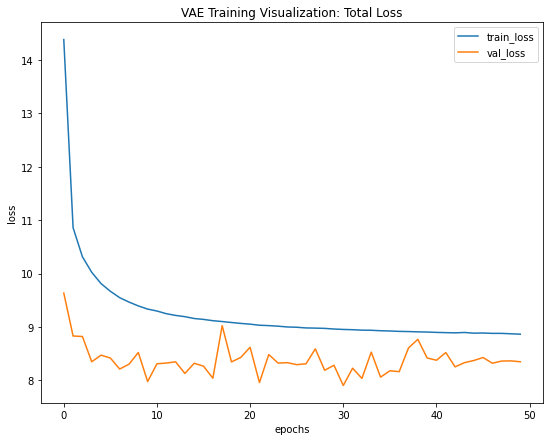

In [43]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.title("VAE Training Visualization: Total Loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

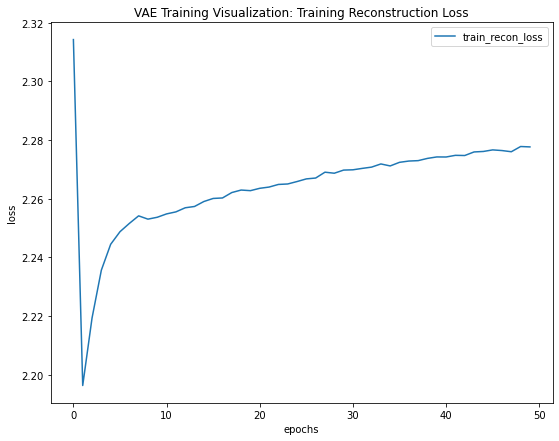

In [47]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.title("VAE Training Visualization: Training Reconstruction Loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

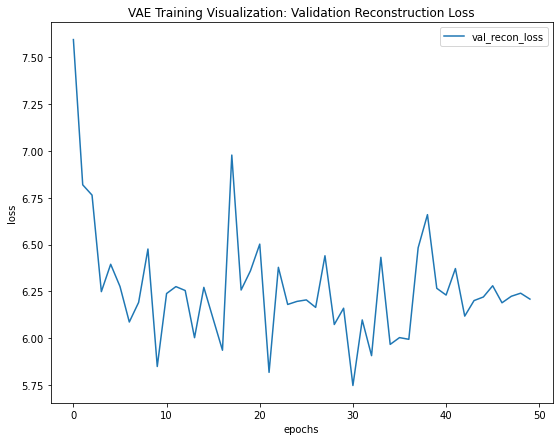

In [48]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.title("VAE Training Visualization: Validation Reconstruction Loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Training and Validation reconstruction losses are on different scales and hence require two separate plots.

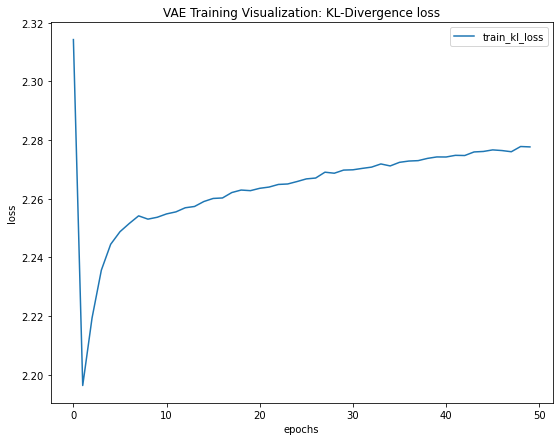

In [50]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.title("VAE Training Visualization: KL-Divergence loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

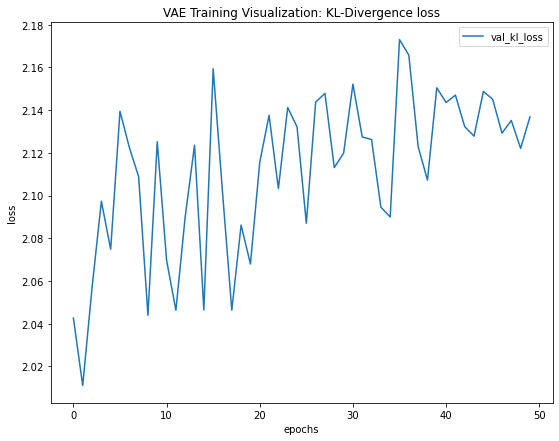

In [51]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.title("VAE Training Visualization: KL-Divergence loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Training and Validation reconstruction losses are on different scales and hence require two separate plots.

In [60]:
# Initialize and load trained weights from before-
trained_model = VAE_CelebA(latent_space = 200).to(device)

In [61]:
trained_model.load_state_dict(torch.load("VAE_CelebA_last_epoch.pth"))

<All keys matched successfully>

In [62]:
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = valid_loader,
    alpha = 1
)

Validation: : 100%|██████████| 312/312 [00:12<00:00, 25.40batch/s]


In [63]:
print(f"Trained model validation metrics: Total loss = {val_loss:.4f}"
      f", KL-div loss = {val_kl_loss:.4f} & reconstruction loss = "
      f"{val_recon_loss:.4f}"
     )

Trained model validation metrics: Total loss = 62.6196, KL-div loss = 0.0003 & reconstruction loss = 62.6193


### Inspect Latent Space

In [103]:
# Python3 list to contain encoded images-
encoded_images = []

In [105]:
k = 0

for images, labels in train_loader:
    if k >= 160:
        break
        
    images = images.to(device)
    with torch.no_grad():
        images_enc = trained_model.encoding_fn(images).to(device)
    
    encoded_images.append(images_enc.cpu().detach().numpy())
    
    k += 1
    

In [111]:
# Sanity check-
len(encoded_images), type(encoded_images)

(160, list)

In [122]:
encoded_images[0].shape, encoded_images[-1].shape

((200,), (200,))

In [121]:
print(f"There are a total of {160 * 64} images process from train_loader")

There are a total of 10240 images process from train_loader


In [119]:
# Convert from list to np arrays-
encoded_images = np.asarray(encoded_images).reshape(160 * 64, 200)

In [120]:
# Sanity check-
encoded_images.shape

(10240, 200)

#### Visualize latent space distributions for 100 encoded images

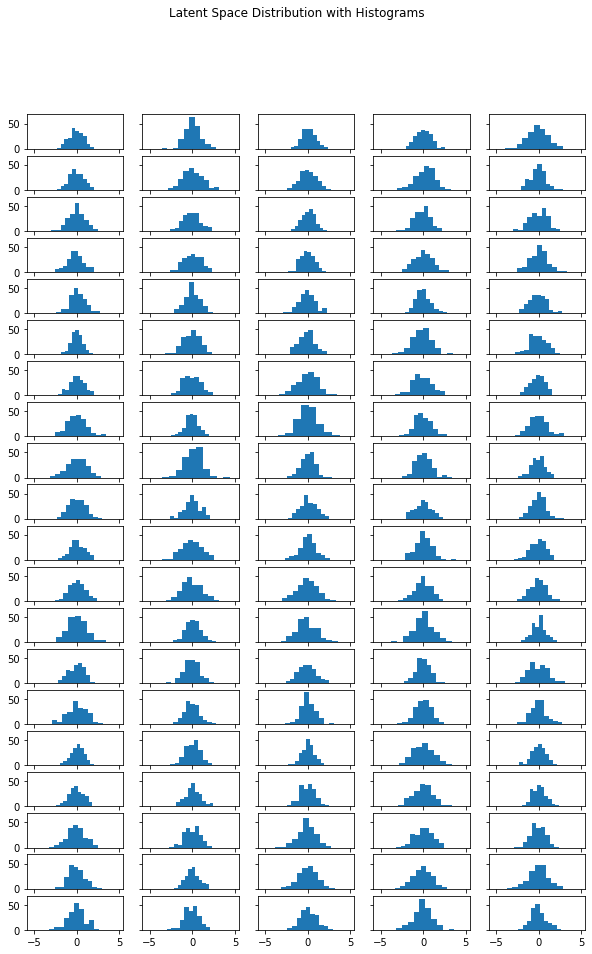

In [123]:
fig, axes = plt.subplots(
    nrows = 20, ncols = 5, 
    sharex = True, sharey = True,
    figsize = (10, 15)
)

i = 0
for row in range(len(axes)):
    for col in range(len(axes[0])):
        axes[row][col].hist(encoded_images[i, :])
        i += 1

plt.suptitle("Latent Space Distribution with Histograms")
plt.show()

In [125]:
del encoded_images, images, images_enc, labels

In [126]:
images, _ = next(iter(train_loader))

In [127]:
images = images.to(device)

In [128]:
recon_images, mu, log_var = trained_model(images)

In [129]:
recon_images.shape, images.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

In [130]:
mu.shape, log_var.shape

(torch.Size([64, 200]), torch.Size([64, 200]))

In [131]:
recon_images = recon_images.cpu().detach().numpy()
images = images.cpu().detach().numpy()

In [132]:
recon_images = np.transpose(recon_images, (0, 2, 3, 1))
images = np.transpose(images, (0, 2, 3, 1))

In [133]:
recon_images.shape, images.shape

((64, 128, 128, 3), (64, 128, 128, 3))

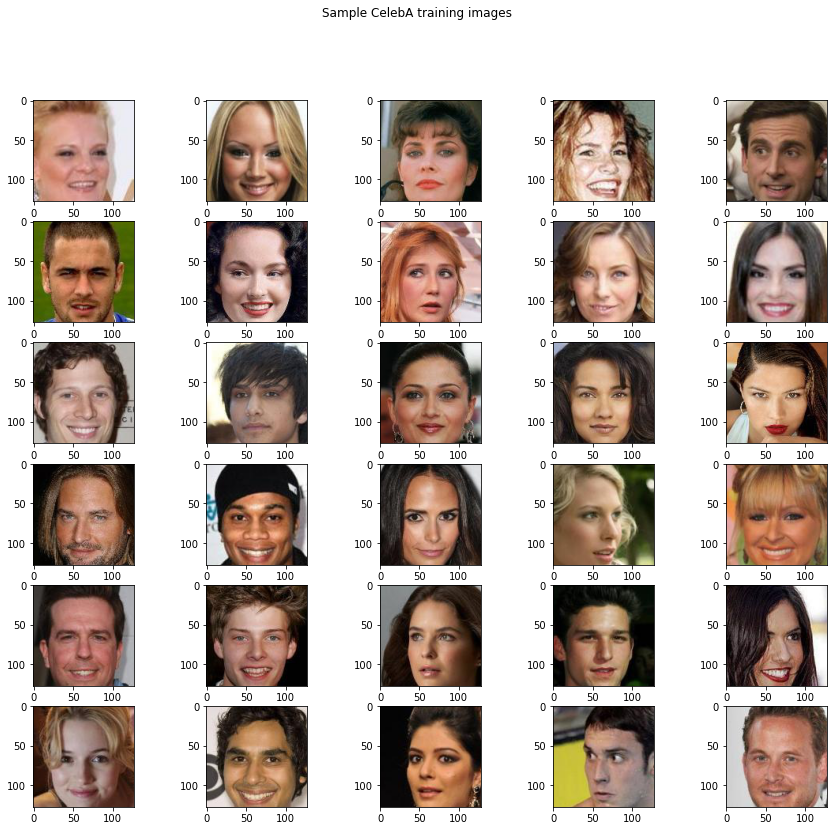

<Figure size 432x288 with 0 Axes>

In [136]:
# Visualize 30 images from training set-
plt.figure(figsize = (15, 13))
for i in range(30):
    # 6 rows & 5 columns-
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CelebA training images")
plt.show()
plt.savefig('Sample_CelebA_training_images.png')

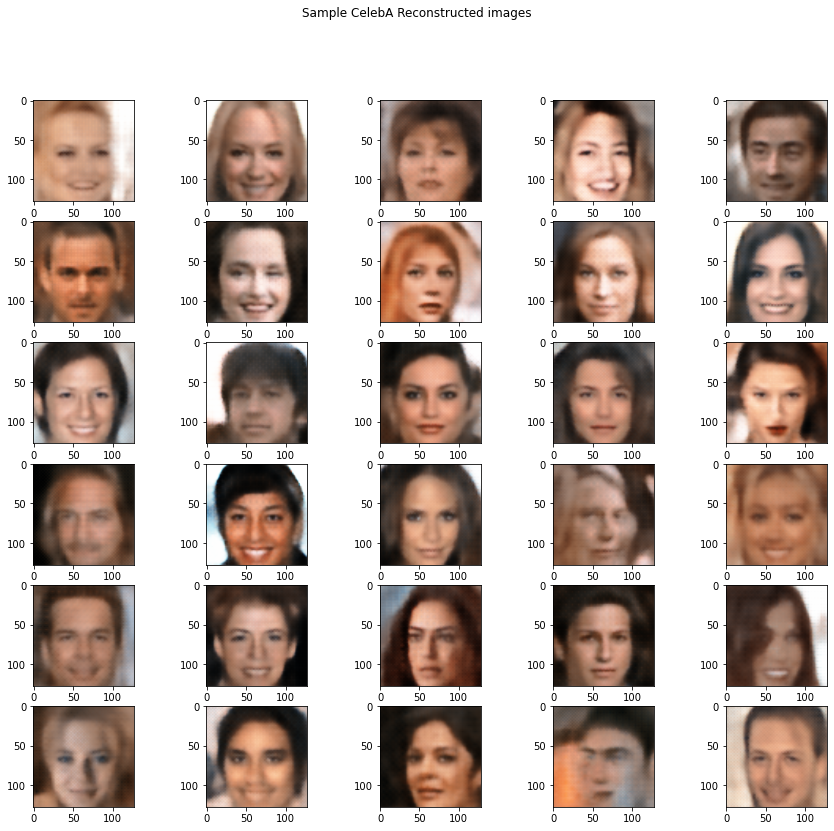

<Figure size 432x288 with 0 Axes>

In [137]:
# Visualize 30 reconstructed images-
plt.figure(figsize = (15, 13))
for i in range(30):
    # 6 rows & 5 columns-
    plt.subplot(6, 5, i + 1)
    plt.imshow(recon_images[i])
    
plt.suptitle("Sample CelebA Reconstructed images")
plt.show()
plt.savefig('Sample_CelebA_Reconstruced_images.png')